In [2]:
# ToDo use additional features
# Cluster transformed series

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import calendar
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


rcParams['figure.figsize'] = 16,4
df = pd.read_csv('database.csv', low_memory=False)
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


North Dakota-1
Vermont-2
South Dakota-3
Montana-4
Wyoming-5
New Hampshire-6
Maine-7
Idaho-8
Delaware-9
Rhodes Island-10
Nebraska-11
Hawaii-12
Alaska-13
Iowa-14
Utah-15
West Virginia-16
Kansas-17
Minnesota-18
Oregon-19
New Mexico-20
Connecticut-21
Nevada-22
Massachusetts-23
Wisconsin-24
Mississippi-25
Kentucky-26
Colorado-27
Arkansas-28
District of Columbia-29
Washington-30
Oklahoma-31
Alabama-32
Indiana-33
South Carolina-34
Arizona-35
New Jersey-36
Missouri-37
Tennessee-38
Virginia-39
Maryland-40
Ohio-41
Louisiana-42
North Carolina-43
Georgia-44
Pennsylvania-45
Illinois-46
Michigan-47
Florida-48
New York-49
Texas-50
California-51


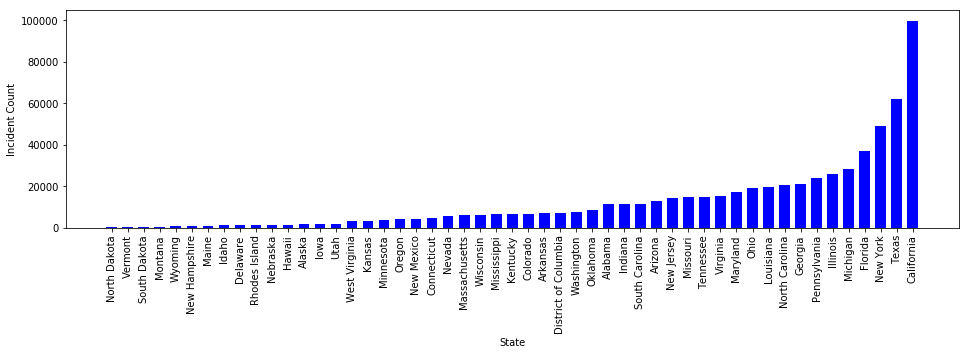

In [3]:
states_total = df[['State', 'Incident']]
states_total = states_total.groupby(['State'],as_index=False).count()
states_total.columns = ['State', 'Incident']

states_total = states_total.sort_values(['Incident'], ascending=[True])
states_list = list(states_total.State)
i = 0
for state in states_list:
    i += 1
    print('{}-{}'.format(state, i))
    
width = 1/1.5
plt.bar(range(51), states_total.Incident, width, color="blue")
plt.xticks(range(51), states_list, rotation=90)
plt.xlabel('State')
plt.ylabel('Incident Count')
plt.show()

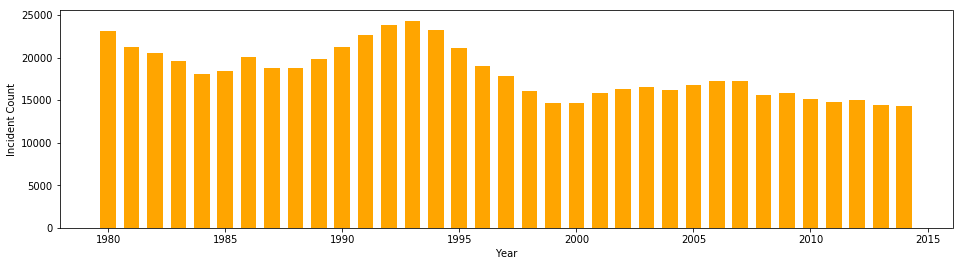

In [4]:
year_total = df[['Year', 'Incident']]
year_total = year_total.groupby(['Year'],as_index=True).count()

year_total = list(year_total[year_total.columns[0]])

width = 1/1.5
plt.bar(range(1980,2015), year_total, width, color="orange")
plt.xlabel('Year')
plt.ylabel('Incident Count')
plt.show()

In [5]:
states = df[['Year', 'Month', 'State', 'Incident']]
states = states.groupby(['Year', 'Month', 'State'], as_index=False)['Incident'].count()

states['Date'] = states.apply(lambda row: '{}-{}'.format(row.Year, row.Month), axis=1)
states.reset_index()
states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states = states[['State', 'Incident', 'Date']]

states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states.reset_index()
states = states.sort_values(['State', 'Date'], ascending=True)
states.head()

,State,Incident,Date
193,Alabama,44,1980-01-01
142,Alabama,31,1980-02-01
337,Alabama,52,1980-03-01
0,Alabama,44,1980-04-01
383,Alabama,43,1980-05-01


In [81]:
idx = pd.date_range(datetime(1980, 1, 1), datetime(2014, 12, 31), freq=pd.tseries.offsets.DateOffset(months=1))

my_series = pd.DataFrame()
for i in range(0,51):
    state = states_list[i]
    x = states.query('State == ["{}"]'.format(state))
    ind = pd.DatetimeIndex(x['Date'])
    x = x.set_index(ind)
    x = x[x.columns[1]]
    x = x.reindex(idx, fill_value=0)
    x = x.fillna(0)
    my_series[state] = pd.Series(x)
    
my_series = (my_series - my_series.mean()) / my_series.std()

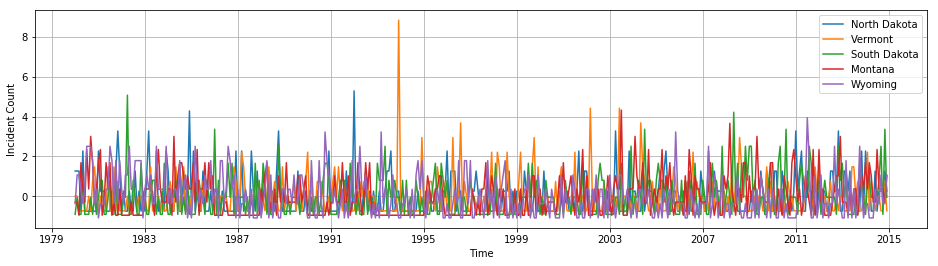

In [83]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(0,5):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('Incident Count')
plt.xlabel('Time')
plt.grid()
plt.show()

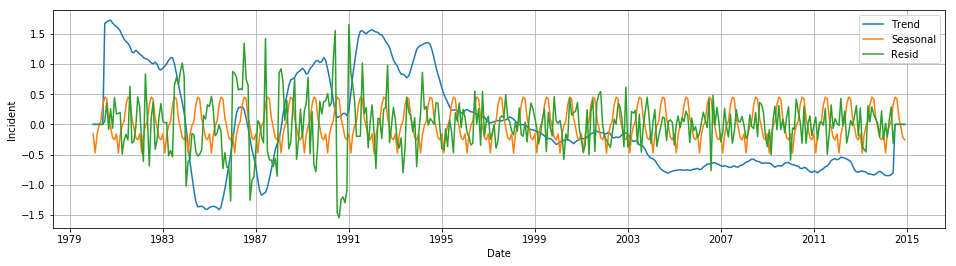

In [84]:
# New York, California, Texas vs Florida

import statsmodels.api as sm

trend = pd.DataFrame()
seasonal = pd.DataFrame()
resid = pd.DataFrame()

for i in range(0,51):
    state = states_list[i]
    res = sm.tsa.seasonal_decompose(my_series[state]) # Illinois - periodic!!!

    trend[state] = res.trend.fillna(0).astype(str).astype(float)
    seasonal[state] = res.seasonal.fillna(0).astype(str).astype(float)
    resid[state] = res.resid.fillna(0).astype(str).astype(float)

state = 'Illinois'
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(trend[state], linestyle='-', label="{}".format('Trend'))
ax.plot(seasonal[state], linestyle='-', label="{}".format('Seasonal'))
ax.plot(resid[state], linestyle='-', label="{}".format('Resid'))
plt.legend(loc='best')
plt.ylabel('Incident')
plt.xlabel('Date')
plt.grid()
plt.show()

In [12]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from math import sqrt

def distance(x,y):
    return abs(x-y)

def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))

ii = 0
def fast_dtw(t1,t2):
    distance, path = fastdtw(t1, t2, dist=euclidean)
    global ii
    ii += 1
    print(ii)
    return distance

def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def DTWDistanceW(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

jj = 0
def distanceW(t1,t2):
    global jj
    jj += 1
    print(jj)
    return DTWDistanceW(t1, t2, 5)

def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return sqrt(LB_sum)

In [339]:
l = 51
dd1 = np.zeros((l, l))
for x in range(l):
    for y in range(l):
#         dd1[x][y] = fast_dtw(my_series[states_list[x]].values, my_series[states_list[y]].values) if y > x else -1
        dd1[x][y] = euclid_dist(my_series[states_list[x]].values, my_series[states_list[y]].values) if y > x else -1
        
dd2 = [[(dd1[x][y] if y > x else dd1[y][x])  for y in range(l)] for x in range(l)]

for i in range(51):
    dd2[i][i] = 0.0
    
dd2

[[0.0,
  30.050042768852045,
  28.922614939722539,
  28.690271547515721,
  29.269548857754014,
  28.578734696403135,
  28.484314510927675,
  28.972604166335856,
  27.545178639188254,
  29.20603780024576,
  28.727356792231181,
  29.731709169182398,
  28.636754130539522,
  29.079663964040904,
  29.883983835269632,
  28.245785793224108,
  27.782901023509524,
  29.325309397840645,
  28.547358163968273,
  28.522512030675024,
  30.198013359961383,
  29.458757123271671,
  29.359903733263959,
  29.183438326204801,
  29.210549666745262,
  29.135773839259336,
  29.155022090631086,
  30.54151575654716,
  29.703350319817009,
  30.101193531881947,
  28.998263531710336,
  29.659290280018055,
  29.163936195793834,
  27.973164206256346,
  30.384460736415182,
  28.43230155583456,
  30.075366372740628,
  27.361654621340492,
  29.340125306015306,
  29.921832733058654,
  28.870205997802255,
  28.683422063231774,
  30.626502615104869,
  30.520730896208573,
  29.132340753049576,
  29.988261015065145,
  29.3

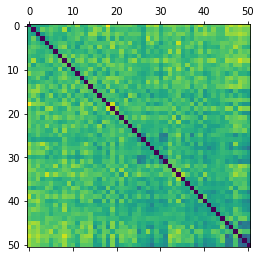

In [86]:
plt.matshow(dd2)
plt.show()

In [165]:
DBSCAN??

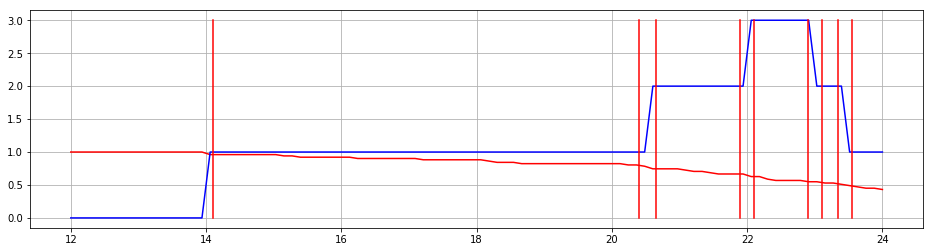

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.])

In [409]:
from sklearn.cluster import DBSCAN
               
# eps_list = np.linspace(0.01, np.amax(dd2), num=200)
eps_list = np.linspace(12, 24, num=100)
noise_list = np.array([])
n_clusters_list = np.array([])
for myeps in eps_list:
#     db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
    noise_list = np.append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = np.append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plt.plot(eps_list, noise_list/51, 'r-')
plt.plot(eps_list, n_clusters_list, 'b-')

# DBSCAN with Eucledean
plt.plot([14.1, 14.1], [0, 3],'r-')
plt.plot([20.4, 20.4], [0, 3],'r-')


plt.plot([20.65, 20.65], [0, 3],'r-')
plt.plot([21.9, 21.9], [0, 3],'r-')

plt.plot([22.1, 22.1], [0, 3],'r-')
plt.plot([22.9, 22.9], [0, 3],'r-')
plt.plot([23.1, 23.1], [0, 3],'r-')
plt.plot([23.35, 23.35], [0, 3],'r-')
plt.plot([23.55, 23.55], [0, 3],'r-')

# DBSCAN with DTW
# plt.plot([148, 148], [0, 4],'r-')
# plt.plot([184, 184], [0, 4],'r-')
# plt.plot([186, 186], [0, 4],'r-')
# plt.plot([216, 216], [0, 4],'r-')
# plt.plot([218, 218], [0, 4],'r-')
# plt.plot([245, 245], [0, 4],'r-')
# plt.plot([247, 247], [0, 4],'r-')
# plt.plot([253, 253], [0, 4],'r-')
# plt.plot([255, 255], [0, 4],'r-')
# plt.plot([257, 257], [0, 4],'r-')
# plt.plot([259, 259], [0, 4],'r-')
# plt.plot([269, 269], [0, 4],'r-')
# plt.plot([271, 271], [0, 4],'r-')
# plt.xticks([148, 184, 186, 216, 218, 245, 247, 253, 255, 257, 259, 269, 271], 
#            [148, 184, 186, 216, 218, 245, 247, 253, 255, 257, 259, 269, 271], rotation=90)
# plt.xticks(range(130, 280), range(130, 280), rotation=90)
plt.grid()
plt.show()
n_clusters_list

In [415]:
db = DBSCAN(21.9, min_samples=2, metric='precomputed').fit(dd2)
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1,  0, -1,  0, -1, -1, -1, -1,  1, -1,  0,  0, -1, -1,  1, -1, -1,
       -1,  0, -1, -1,  0,  0,  0, -1,  0, -1, -1,  0,  0, -1,  0,  0,  0])

Stress value:  21504015.981


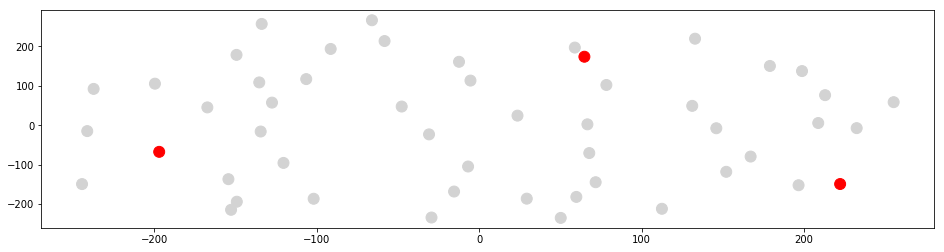

In [156]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=152, dissimilarity="precomputed", n_jobs=4)
pos = mds.fit(dd2)
print ("Stress value: ", pos.stress_)

# Assign colors based on clusters
db = DBSCAN(eps=152, min_samples=2, metric='precomputed').fit(dd2)
cols = ['lightgray', 'red', 'green', 'orange', 'blue', 'yellow', 'black']
cc = [ cols[l+1] for l in db.labels_]
plt.scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)
plt.show()

Kentucky
Alabama


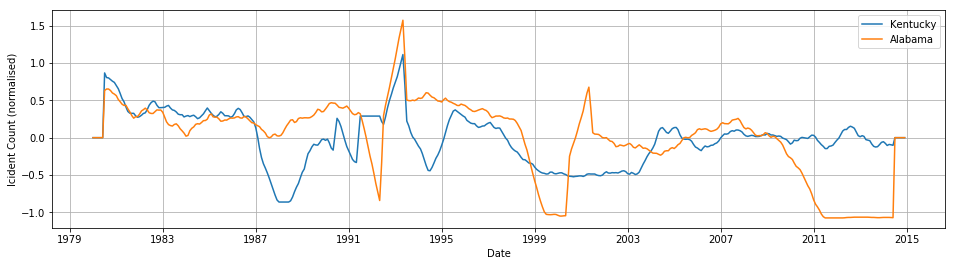

In [418]:
fig = plt.figure()
ax = plt.subplot(111)

k = 0
for i in range(len(states_list)):
#     if k > 4:
#         break
    state = states_list[i]
    
    if db.labels_[i] == 1:
        print(state)
#         ax.plot(my_series[state], linestyle='-')
        ax.plot(trend[state], linestyle='-', label="{}".format(state))
#         ax.plot(seasonal[state], linestyle='-')
#         ax.plot(resid[state], linestyle='-')
        k += 1

plt.legend(loc='best')
plt.ylabel('Icident Count (normalised)')
plt.xlabel('Date')
plt.grid()
plt.show()

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

resid.dropna(inplace=True)
test_stationarity(resid)

In [ ]:
ts = my_series['New York']
ts_log = np.log(ts) # Illinois
plt.plot(ts_log)
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

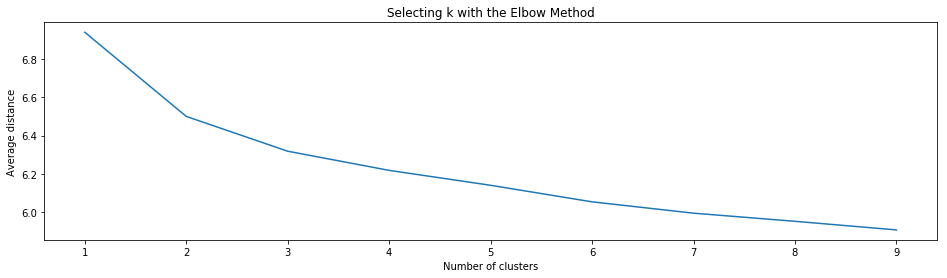

In [456]:
from sklearn.cluster import KMeans
# K-means cluster analysis for 1-10 clusters due to the 10 possible class outcomes for poker hands

clusters=range(1, 10)
meandist=[]

# Loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean distance my taking the sum divided by the shape

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(trend)
    clusassign=model.predict(my_series)
    meandist.append(sum(np.min(cdist(my_series, model.cluster_centers_, 'euclidean'), axis=1))
    / my_series.shape[0])
    
# Choose the best cluster number with Elbow rule

"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') # pick the fewest number of clusters that reduces the average distance
plt.show()

In [70]:
KMeans??

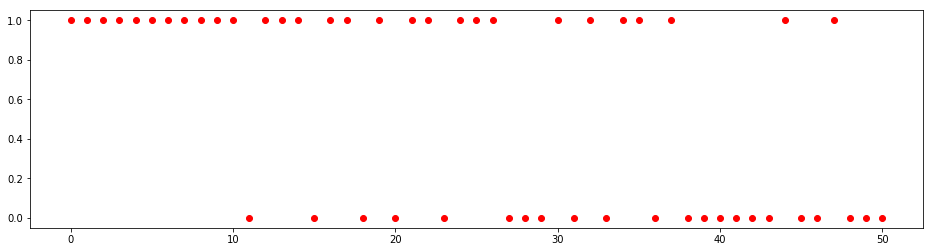

In [477]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters, init='random') # k-means++ random
km.fit(trend.T)
plt.plot(km.labels_, 'ro')
plt.show()

In [478]:
labels = km.predict(my_series.T)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0], dtype=int32)

Hawaii
West Virginia
Oregon
Connecticut
Wisconsin
Arkansas
District of Columbia
Washington
Alabama
South Carolina
Missouri
Virginia
Maryland
Ohio
Louisiana
North Carolina
Georgia
Illinois
Michigan
New York
Texas
California


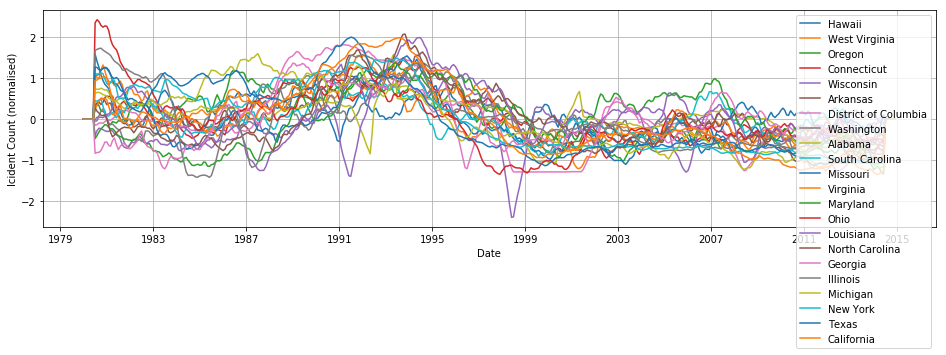

In [481]:
fig = plt.figure()
ax = plt.subplot(111)

for i in range(len(states_list)):
    state = states_list[i]
    
    if labels[i] == 0:
        print(state)
#         ax.plot(my_series[state], linestyle='-')
        ax.plot(trend[state], linestyle='-', label="{}".format(state))
#         ax.plot(seasonal[state], linestyle='-')
#         ax.plot(resid[state], linestyle='-')

plt.legend(loc='best')
plt.ylabel('Icident Count (normalised)')
plt.xlabel('Date')
plt.grid()
plt.show()